# Import libraries

In [1]:
import pandas as pd
import pandas_profiling

In [2]:
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
%matplotlib inline

In [3]:
# reading the document
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
# Marking from which dataset the data comes and concating them
train['train'] = 1
test['train'] = 0
test['default'] = 2  # creating a column to concate
banking = pd.concat([train, test], ignore_index=True)

In [5]:
banking.profile_report()

In [5]:
# For making future work easier create lists with types of data in columns
target = 'default'
time_cols = ['app_date']
cat_cols = ['education',  'home_address',
            'work_address', 'sna', 'first_time', 'age_cat']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
num_cols = ['age', 'decline_app_cnt', 'region_rating',
            'score_bki', 'bki_request_cnt', 'income']
# client id is not needed
banking.drop('client_id', axis=1, inplace=True)

# Time

In [6]:
# need to reform time columns first
banking['app_date'] = pd.to_datetime(banking['app_date'], format='%d%b%Y')
# Need to get all the data possible - will decide what to do later
banking['day'] = banking['app_date'].dt.day
banking['month'] = banking['app_date'].dt.month
banking['year'] = banking['app_date'].dt.year

In [7]:
time_cols_2 = ['day', 'month', 'year']
banking.loc[:, time_cols_2].describe()

day          month      year
count  110148.000000  110148.000000  110148.0
mean       15.959100       2.535107    2014.0
std         8.598467       1.087680       0.0
min         1.000000       1.000000    2014.0
25%         9.000000       2.000000    2014.0
50%        16.000000       3.000000    2014.0
75%        23.000000       3.000000    2014.0
max        31.000000       4.000000    2014.0

In [8]:
# The only year present is 2014, so the year is not needed
banking.drop('year', axis=1, inplace=True)

In [9]:
# As the year is only 2014, it is logical to count days from 1st january 2014
st_jan_2014 = pd.to_datetime('1/1/2014')
banking['delta_t'] = (banking['app_date']-st_jan_2014).dt.days

In [10]:
# As I've agglomerated the time data into delta, we dont need other time columns
banking.drop(['day', 'app_date', 'month'], axis=1, inplace=True)

In [11]:
banking

education sex  age car car_type  decline_app_cnt  good_work  score_bki  \
0            SCH   M   62   Y        Y                0          0  -2.008753   
1            SCH   F   59   N        N                0          0  -1.532276   
2            SCH   M   25   Y        N                2          0  -1.408142   
3            SCH   F   53   N        N                0          0  -2.057471   
4            GRD   M   48   N        N                0          1  -1.244723   
...          ...  ..  ...  ..      ...              ...        ...        ...   
110143       SCH   F   37   N        N                1          0  -1.744976   
110144       GRD   F   64   Y        Y                0          0  -2.293781   
110145       GRD   M   31   N        N                2          0  -0.940752   
110146       UGR   F   27   N        N                1          0  -1.242392   
110147       SCH   M   38   N        N                0          0  -1.507549   

        bki_request_cnt  region_rating  home_address  work_address  income  \
0                     1             50             1             2   18000   
1                     3             50             2             3   19000   
2                     1             80             1             2   30000   
3                     2             50             2             3   10000   
4                     1             60             2             3   30000   
...                 ...            ...           ...           ...     ...   
110143                3             50             2             3   15000   
110144                3             60             1             2  200000   
110145                1             50             1             2   60000   
110146                2             80             2             3   30000   
110147                2             50             1             2   15000   

        sna  first_time foreign_passport  default  train  delta_t  
0         4           1                N        0      1       31  
1         4           1                N        0      1       70  
2         1           4                Y        0      1       31  
3         1           3                N        0      1       22  
4         1           4                Y        0      1      107  
...     ...         ...              ...      ...    ...      ...  
110143    4           1                N        2      0       89  
110144    1           4                N        2      0      114  
110145    4           2                N        2      0       88  
110146    1           1                N        2      0        6  
110147    4           2                N        2      0       75  

[110148 rows x 19 columns]

# Education

In [12]:
# Education is the only column, which has NONEs
banking.isna().sum()

education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
train                 0
delta_t               0
dtype: int64

In [13]:
# Filling them with the most often value
banking['education'].fillna('SCH', inplace=True)

# Binaries

In [14]:
# Making binary columns usable for logistic regression-use LabelEncoder
lable_enc = LabelEncoder()
for col in bin_cols:
    banking[col] = lable_enc.fit_transform(banking[col])

# Feature Engineering

In [15]:
# average income per age group
mean_income = banking.groupby('age')['income'].mean().to_dict()
banking['mean_income_age'] = banking['age'].map(mean_income)

In [16]:
# Difference between real income and average from the group may be important
banking['dif_income_age'] = banking['income']-banking['mean_income_age']
banking

education  sex  age  car  car_type  decline_app_cnt  good_work  \
0            SCH    1   62    1         1                0          0   
1            SCH    0   59    0         0                0          0   
2            SCH    1   25    1         0                2          0   
3            SCH    0   53    0         0                0          0   
4            GRD    1   48    0         0                0          1   
...          ...  ...  ...  ...       ...              ...        ...   
110143       SCH    0   37    0         0                1          0   
110144       GRD    0   64    1         1                0          0   
110145       GRD    1   31    0         0                2          0   
110146       UGR    0   27    0         0                1          0   
110147       SCH    1   38    0         0                0          0   

        score_bki  bki_request_cnt  region_rating  ...  work_address  income  \
0       -2.008753                1             50  ...             2   18000   
1       -1.532276                3             50  ...             3   19000   
2       -1.408142                1             80  ...             2   30000   
3       -2.057471                2             50  ...             3   10000   
4       -1.244723                1             60  ...             3   30000   
...           ...              ...            ...  ...           ...     ...   
110143  -1.744976                3             50  ...             3   15000   
110144  -2.293781                3             60  ...             2  200000   
110145  -0.940752                1             50  ...             2   60000   
110146  -1.242392                2             80  ...             3   30000   
110147  -1.507549                2             50  ...             2   15000   

        sna  first_time  foreign_passport  default  train  delta_t  \
0         4           1                 0        0      1       31   
1         4           1                 0        0      1       70   
2         1           4                 1        0      1       31   
3         1           3                 0        0      1       22   
4         1           4                 1        0      1      107   
...     ...         ...               ...      ...    ...      ...   
110143    4           1                 0        2      0       89   
110144    1           4                 0        2      0      114   
110145    4           2                 0        2      0       88   
110146    1           1                 0        2      0        6   
110147    4           2                 0        2      0       75   

        mean_income_age  dif_income_age  
0          28025.405650   -10025.405650  
1          29799.811194   -10799.811194  
2          35853.015188    -5853.015188  
3          42983.164141   -32983.164141  
4          46150.815259   -16150.815259  
...                 ...             ...  
110143     44902.437363   -29902.437363  
110144     26022.867270   173977.132730  
110145     43755.296033    16244.703967  
110146     39236.883451    -9236.883451  
110147     46022.711726   -31022.711726  

[110148 rows x 21 columns]

In [17]:
# average income per region
mean_income = banking.groupby('age')['region_rating'].mean().to_dict()
banking['mean_income_region'] = banking['age'].map(mean_income)
# Difference between real income and average from the group may be important
banking['dif_income_region'] = banking['income']-banking['mean_income_region']

In [18]:
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'income', 'bki_request_cnt',
            'region_rating', 'mean_income_age', 'mean_income_region', 'delta_t']  # numerical
cat_cols = ['education', 'work_address',
            'home_address', 'sna', 'first_time']  # categorical
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [19]:
# lets try to make age cathegorical
def age_cat(age):
    if age <= 25:
        cat_age = 'young'
        return cat_age
    if 28 < age <= 35:
        cat_age = 'middle age'
        return cat_age
    if 35 < age <= 50:
        cat_age = 'upper_middle'
        return cat_age
    else:
        cat_age = 'senior'
        return cat_age

# Categorial

In [20]:
cat_cols = ['education',  'home_address',
            'work_address', 'sna', 'first_time', 'age_cat']

In [21]:
banking['age_cat'] = 0  # create age_categorical column
banking['age_cat'] = banking['age'].apply(lambda x: age_cat(x))

In [22]:
# Need to change str to int - Use OneHotEncoder
X_cat_train = OneHotEncoder(sparse=False).fit_transform(
    banking[banking.train == 1][cat_cols].values)
X_cat_test = OneHotEncoder(sparse=False).fit_transform(
    banking[banking.train == 0][cat_cols].values)
# will use it later

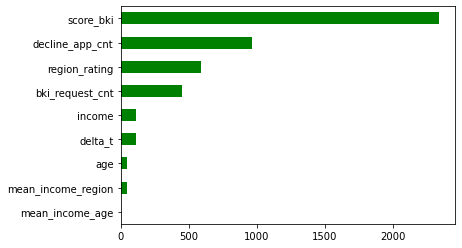

In [23]:
imp_num = pd.Series(f_classif(banking[banking.train == 1][num_cols],
                              banking[banking.train == 1]['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', color='green')

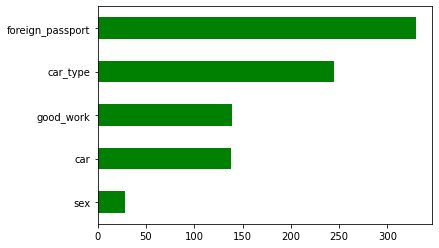

In [24]:
imp_num = pd.Series(f_classif(banking[banking.train == 1][bin_cols],
                              banking[banking.train == 1]['default'])[0], index=bin_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', color='green')

# Distribution

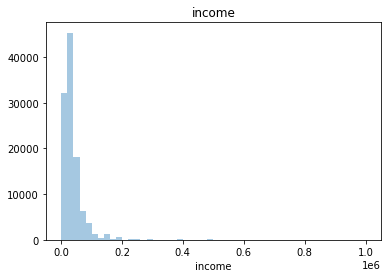

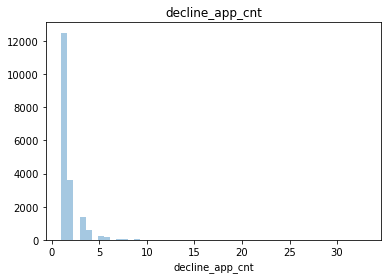

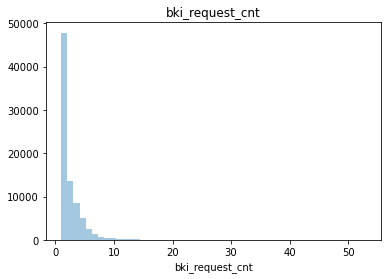

In [25]:
for i in ['income', 'decline_app_cnt', 'bki_request_cnt']:
    plt.figure()
    sns.distplot(banking[i][banking[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

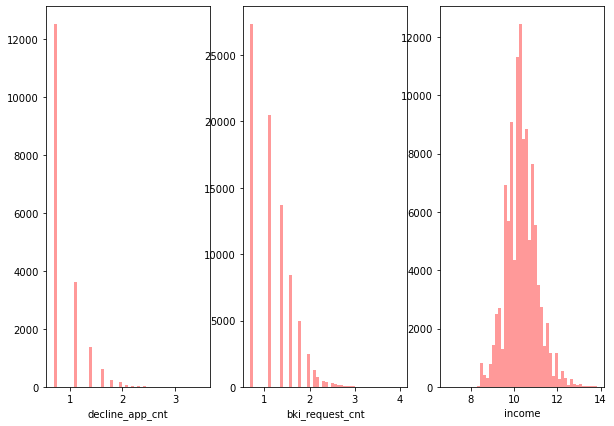

In [26]:
# Can be seen that values are strongly inclined to the left - trying log[log+1 to avoid mathematical error]
fig, axes = plt.subplots(1, 3, figsize=(10, 7))
for i, col in enumerate(['decline_app_cnt', 'bki_request_cnt', 'income']):
    banking[col] = np.log(banking[col] + 1)
    sns.distplot(banking[col][banking[col] > 0].dropna(),
                 ax=axes.flat[i], kde=False, rug=False, color="r")

age
decline_app_cnt


C:\Users\Dmitry Trushin\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


score_bki
income
bki_request_cnt
region_rating
mean_income_age
mean_income_region
delta_t


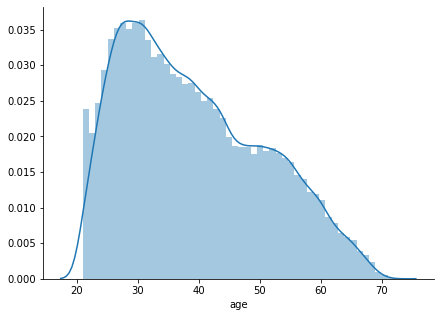

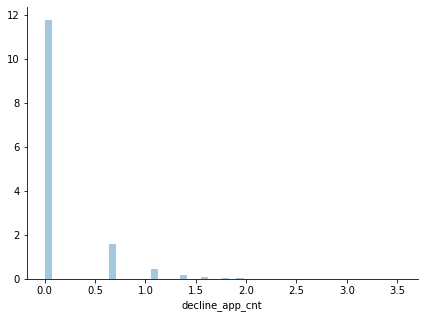

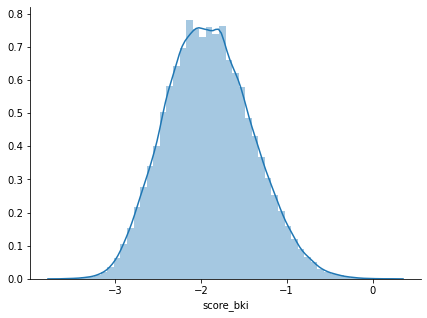

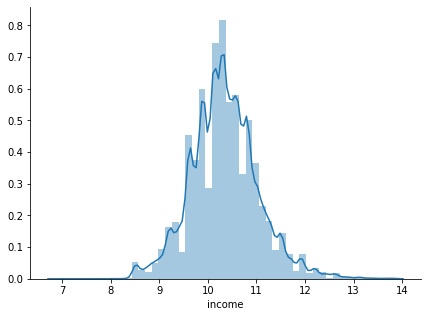

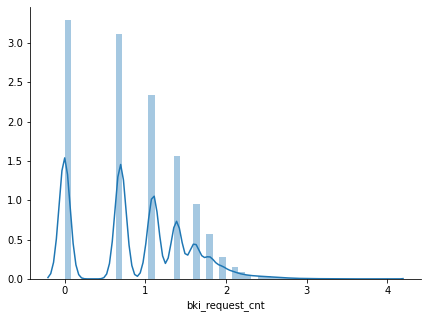

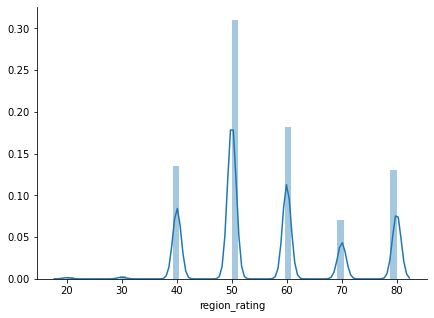

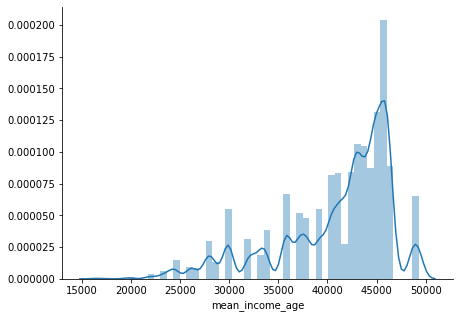

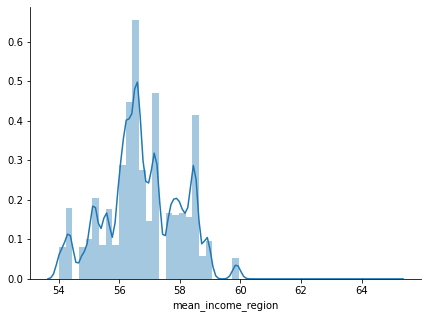

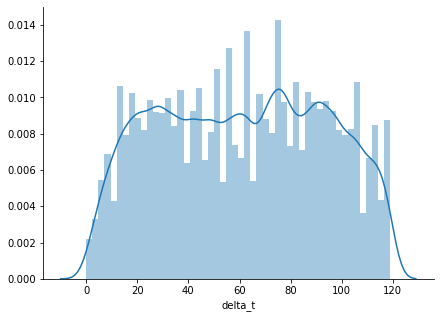

In [27]:
# Lets analyze numerical columns more thoroughly
for col in num_cols:
    print(col)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.despine(f)
    sns.distplot(
        banking[col])

age


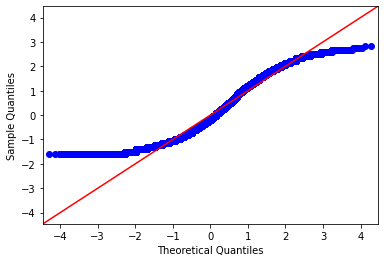

decline_app_cnt


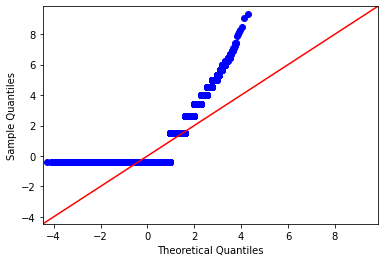

score_bki


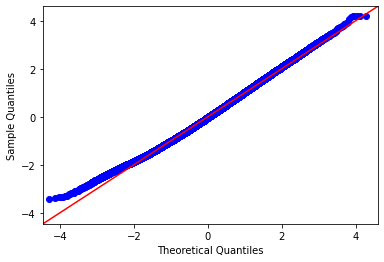

income


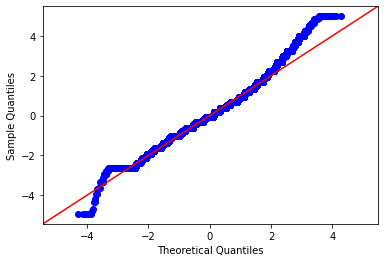

bki_request_cnt


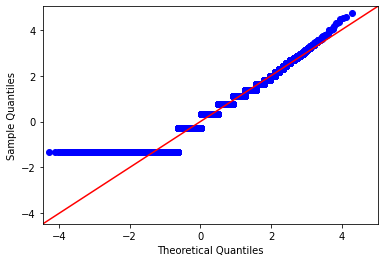

region_rating


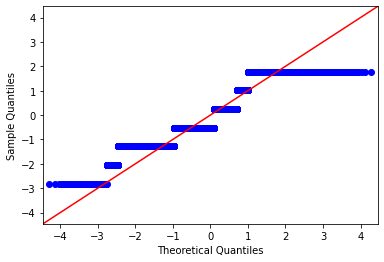

mean_income_age


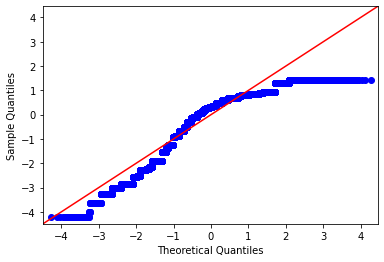

mean_income_region


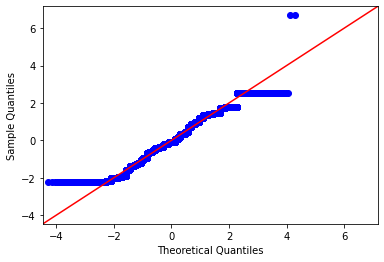

delta_t


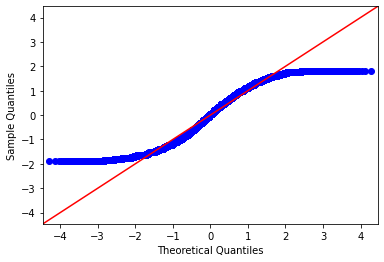

In [28]:
# use qq to determine whether the distribution is eneven
import statsmodels.api as sm
import pylab
for col in num_cols:
    print(col)
    sm.qqplot(banking[col], line='45', fit=True)
    pylab.show()

age


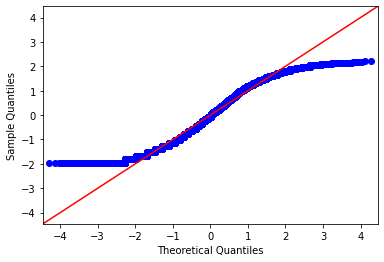

decline_app_cnt


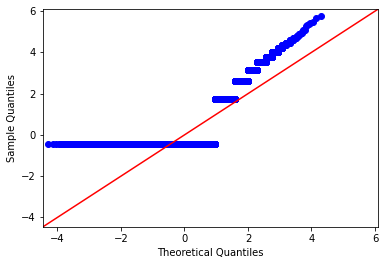

bki_request_cnt


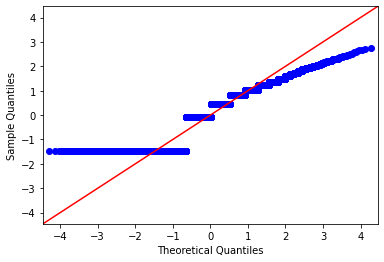

income


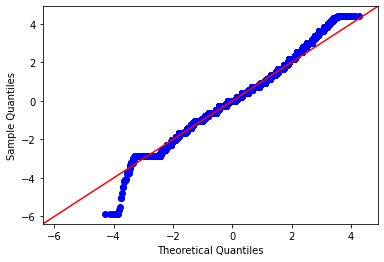

In [29]:
quest_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for col in quest_cols:
    print(col)
    sm.qqplot((banking[col]+1).transform(np.log), line='45', fit=True)
    pylab.show()

age
decline_app_cnt


C:\Users\Dmitry Trushin\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


score_bki
income
bki_request_cnt
region_rating
mean_income_age
mean_income_region
delta_t


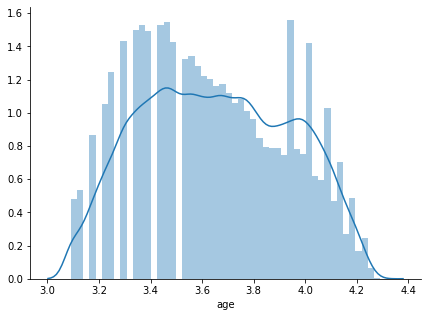

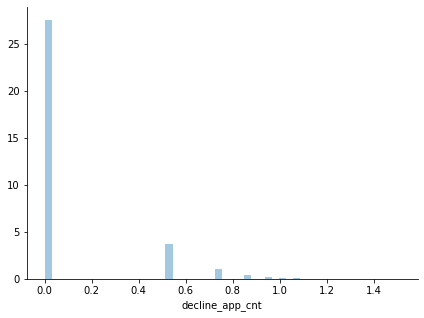

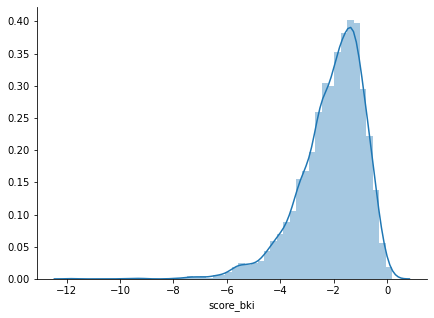

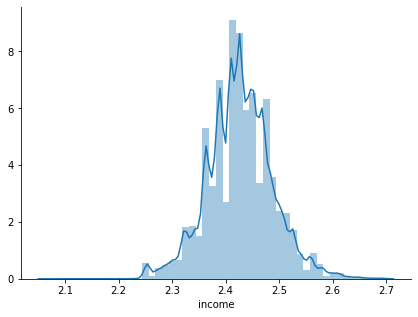

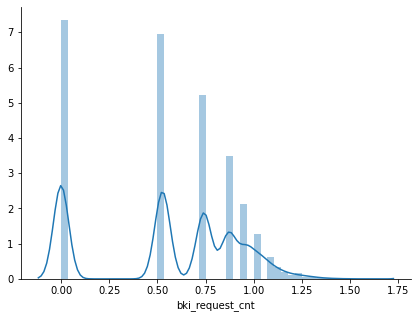

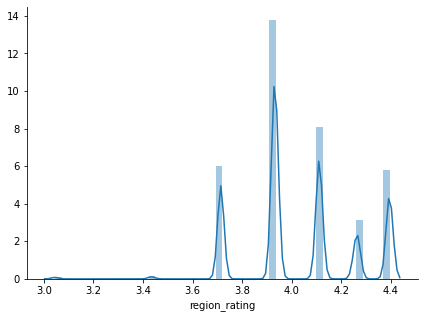

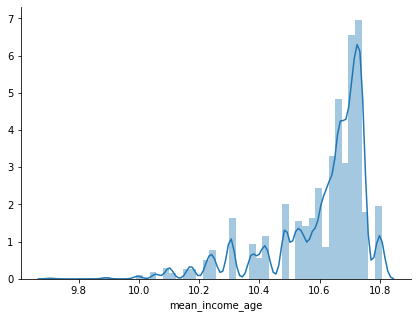

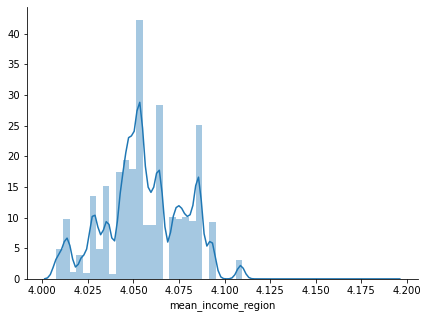

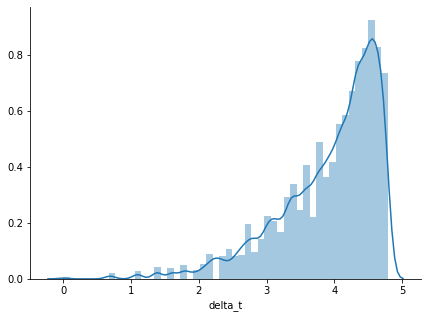

In [30]:
for col in num_cols:
    print(col)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.despine(f)
    sns.distplot(
        (banking[col]+1).transform(np.log))

In [31]:
# per graphs, we should apply log to age, decline_app_cnt,income
log_cols = ['age', 'decline_app_cnt', 'income']
for col in log_cols:
    banking[col] = (banking[col]+1).transform(np.log)

In [32]:
banking

education  sex       age  car  car_type  decline_app_cnt  good_work  \
0            SCH    1  4.143135    1         1         0.000000          0   
1            SCH    0  4.094345    0         0         0.000000          0   
2            SCH    1  3.258097    1         0         0.741276          0   
3            SCH    0  3.988984    0         0         0.000000          0   
4            GRD    1  3.891820    0         0         0.000000          1   
...          ...  ...       ...  ...       ...              ...        ...   
110143       SCH    0  3.637586    0         0         0.526589          0   
110144       GRD    0  4.174387    1         1         0.000000          0   
110145       GRD    1  3.465736    0         0         0.741276          0   
110146       UGR    0  3.332205    0         0         0.526589          0   
110147       SCH    1  3.663562    0         0         0.000000          0   

        score_bki  bki_request_cnt  region_rating  ...  first_time  \
0       -2.008753         0.693147             50  ...           1   
1       -1.532276         1.386294             50  ...           1   
2       -1.408142         0.693147             80  ...           4   
3       -2.057471         1.098612             50  ...           3   
4       -1.244723         0.693147             60  ...           4   
...           ...              ...            ...  ...         ...   
110143  -1.744976         1.386294             50  ...           1   
110144  -2.293781         1.386294             60  ...           4   
110145  -0.940752         0.693147             50  ...           2   
110146  -1.242392         1.098612             80  ...           1   
110147  -1.507549         1.098612             50  ...           2   

        foreign_passport  default  train  delta_t  mean_income_age  \
0                      0        0      1       31     28025.405650   
1                      0        0      1       70     29799.811194   
2                      1        0      1       31     35853.015188   
3                      0        0      1       22     42983.164141   
4                      1        0      1      107     46150.815259   
...                  ...      ...    ...      ...              ...   
110143                 0        2      0       89     44902.437363   
110144                 0        2      0      114     26022.867270   
110145                 0        2      0       88     43755.296033   
110146                 0        2      0        6     39236.883451   
110147                 0        2      0       75     46022.711726   

        dif_income_age  mean_income_region  dif_income_region       age_cat  
0        -10025.405650           54.271186       17945.728814        senior  
1        -10799.811194           55.223881       18944.776119        senior  
2         -5853.015188           58.520656       29941.479344         young  
3        -32983.164141           55.252525        9944.747475        senior  
4        -16150.815259           56.041267       29943.958733  upper_middle  
...                ...                 ...                ...           ...  
110143   -29902.437363           56.665620       14943.334380  upper_middle  
110144   173977.132730           54.268477      199945.731523        senior  
110145    16244.703967           57.291871       59942.708129    middle age  
110146    -9236.883451           58.428355       29941.571645        senior  
110147   -31022.711726           56.543974       14943.456026  upper_middle  

[110148 rows x 24 columns]

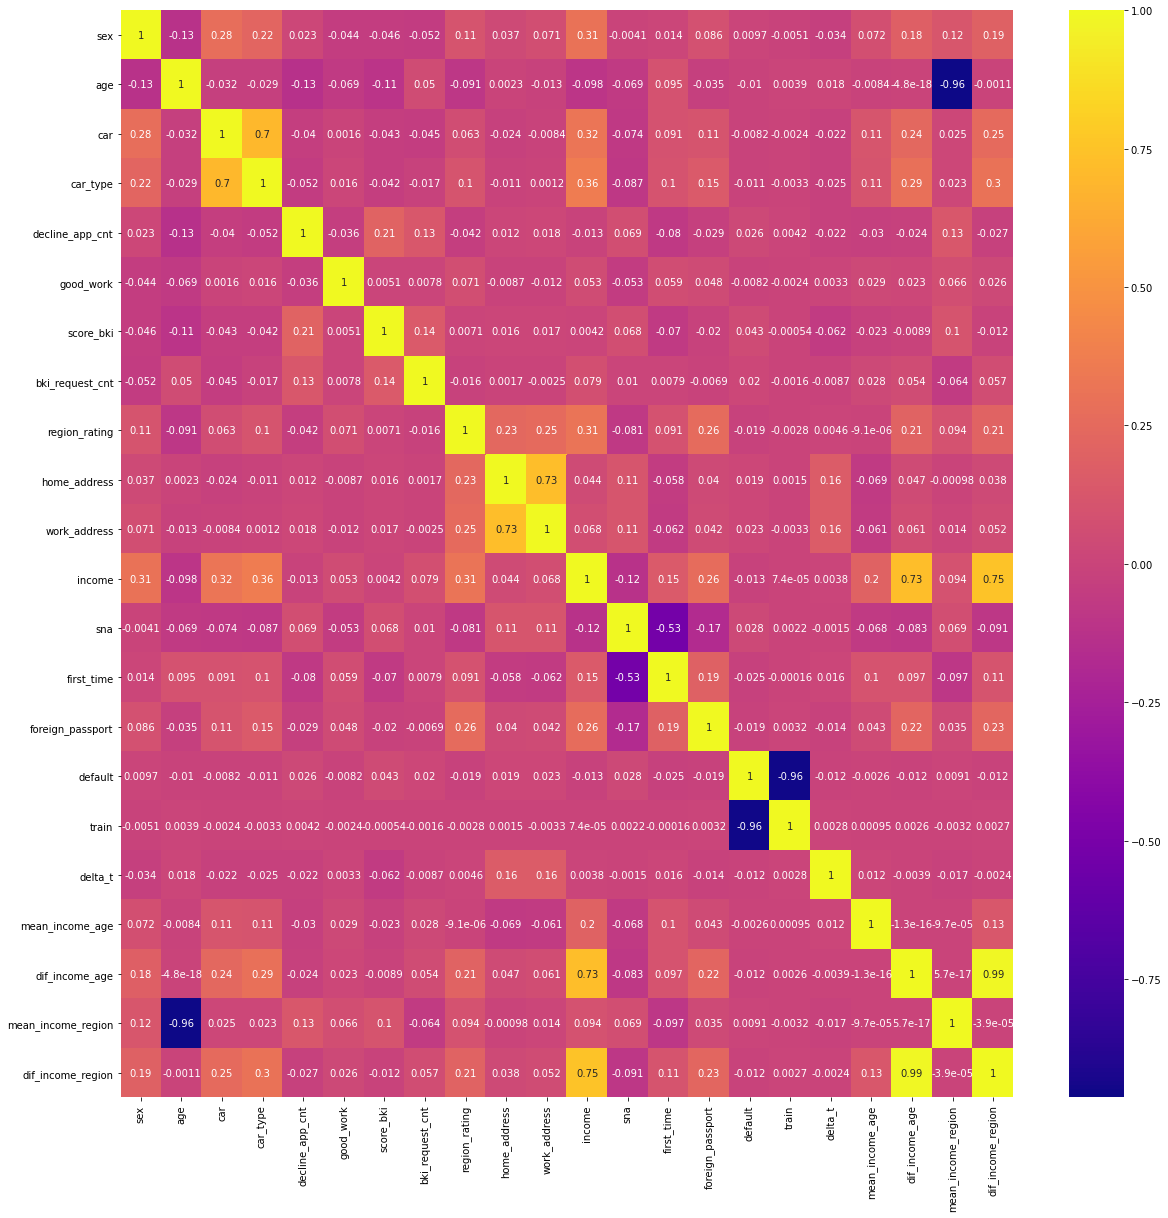

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = sns.heatmap(banking.corr(), annot=True, cmap='plasma')

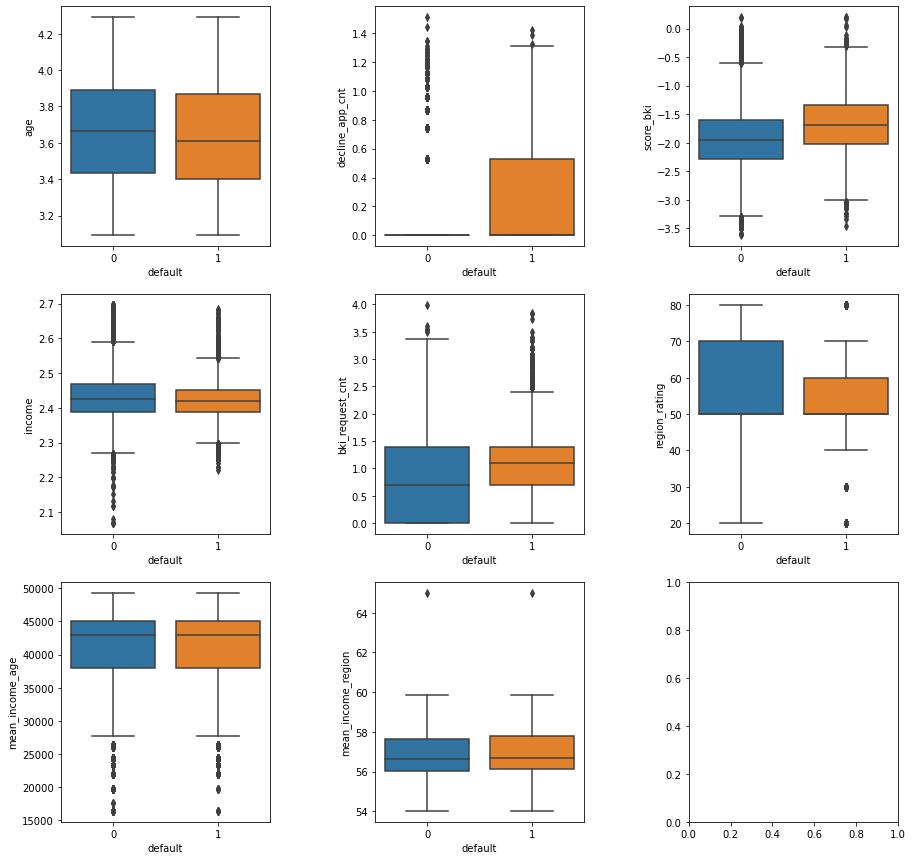

In [34]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
for i in range(len(num_cols)-1):
    sns.boxplot(
        x="default", y=num_cols[i], data=banking[banking['train'] == 1], orient='v', ax=axes[i])

# Scaling

In [35]:
scaler = RobustScaler()
X_num_train = scaler.fit_transform(
    banking[banking.train == 1][num_cols].values)
X_num_test = scaler.fit_transform(banking[banking.train == 0][num_cols].values)

# LogisticRegression

In [36]:
train = banking[banking['train'] == 1]
test = banking[banking['train'] == 0]

X = np.hstack([X_num_train, train[bin_cols].values, X_cat_train])
y = train['default'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23, shuffle=True)

In [88]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
# Add regularisation types
penalty = ['l1', 'l2']
# Add restrictions fo rregularisation
C = np.logspace(0, 4, 10)
# Add hyperparameters
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_train, y_train)
# Create the Grid
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)
# View best hyperparameters
c = best_model.best_estimator_.get_params()['C']
penalty = best_model.best_estimator_.get_params()['penalty']
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


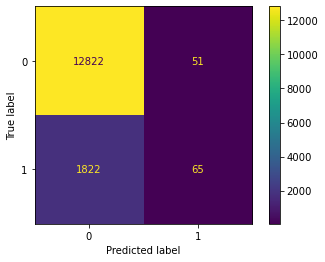

In [38]:
model = LogisticRegression(C=c, penalty=penalty, max_iter=1000)
model.fit(X_train, y_train)
plot_confusion_matrix(model, X_test, y_test)
plt.show()

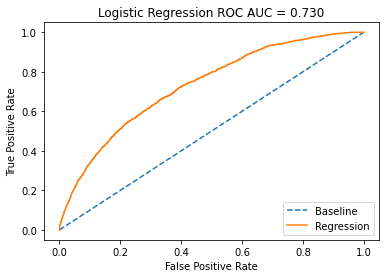

In [39]:
probs = model.predict_proba(X_test)
probs = probs[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [40]:
# Lets try class_weight == 'balanced'

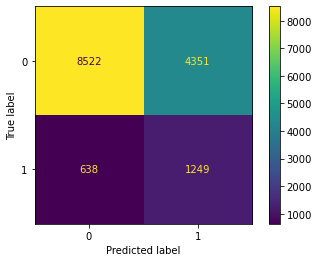

In [41]:
model = LogisticRegression(C=c, penalty=penalty, class_weight='balanced')
model.fit(X_train, y_train)
plot_confusion_matrix(model, X_test, y_test)
plt.show()

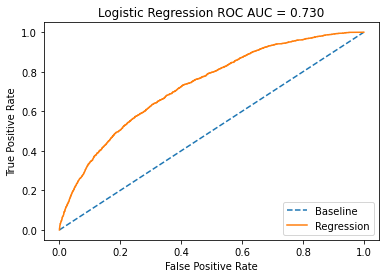

In [42]:
probs = model.predict_proba(X_test)
probs = probs[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

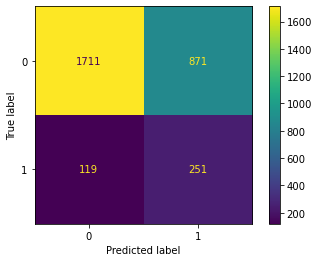

In [43]:
# Check on test part
X_t = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])
y_t = test['default'].values
X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(
    X_test, y_test, test_size=0.2, random_state=23, shuffle=True)
model = LogisticRegression(C=c, penalty=penalty, class_weight='balanced')
model.fit(X_t_train, y_t_train)
plot_confusion_matrix(model, X_t_test, y_t_test)
plt.show()

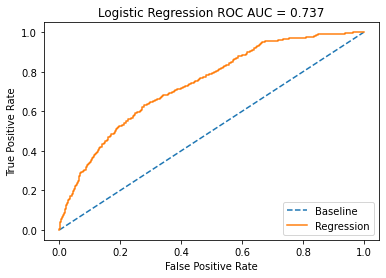

In [44]:
probs_t = model.predict_proba(X_t_test)
probs_t = probs_t[:, 1]


fpr, tpr, threshold = roc_curve(y_t_test, probs_t)
roc_auc = roc_auc_score(y_t_test, probs_t)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [45]:
print('accuracy_score:', accuracy_score(y_test, model.predict(X_test)))
print('precision_score:', precision_score(y_test, model.predict(X_test)))
print('recall_score:', recall_score(y_test, model.predict(X_test)))
print('f1_score:', f1_score(y_test, model.predict(X_test)))

accuracy_score: 0.664159891598916
precision_score: 0.22579492675955698
recall_score: 0.6698463169051404
f1_score: 0.3377421509686038


We can see that our model has very low recall, which shows that it has too much FN

In [46]:
# Let's try oversampling

In [47]:
oversample = RandomOverSampler(sampling_strategy=1)
X_ov, y_ov = oversample.fit_resample(X, y)

In [48]:
X_ov_train, X_ov_test, y_ov_train, y_ov_test = train_test_split(
    X_ov, y_ov, test_size=0.2, shuffle=True, random_state=23
)

In [49]:
warnings.filterwarnings("ignore")
# Add regularisation types
penalty = ['l1', 'l2']
# Add restrictions fo rregularisation
C = np.logspace(0, 4, 10)
# Add hyperparameters
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_ov_train, y_ov_train)
# Create the Grid
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_ov_train, y_ov_train)
# View best hyperparameters
c = best_model.best_estimator_.get_params()['C']
penalty = best_model.best_estimator_.get_params()['penalty']
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


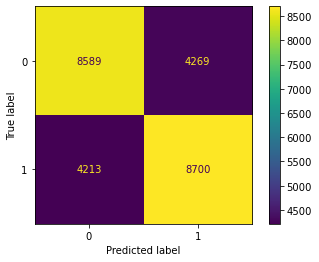

In [50]:
model = LogisticRegression(C=c, penalty=penalty, max_iter=1000)
model.fit(X_ov_train, y_ov_train)
plot_confusion_matrix(model, X_ov_test, y_ov_test)
plt.show()

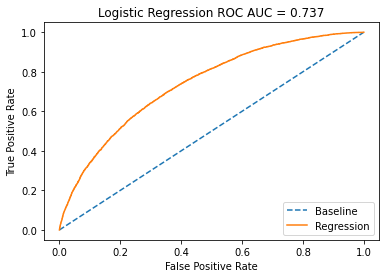

In [51]:
probs = model.predict_proba(X_ov_test)
probs = probs[:, 1]


fpr, tpr, threshold = roc_curve(y_ov_test, probs)
roc_auc = roc_auc_score(y_ov_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [52]:
print('accuracy_score:', accuracy_score(y_ov_test, model.predict(X_ov_test)))
print('precision_score:', precision_score(y_ov_test, model.predict(X_ov_test)))
print('recall_score:', recall_score(y_ov_test, model.predict(X_ov_test)))
print('f1_score:', f1_score(y_ov_test, model.predict(X_ov_test)))

accuracy_score: 0.6708703581545148
precision_score: 0.6708304418228083
recall_score: 0.6737396422210176
f1_score: 0.6722818947531104


In [53]:
# It is clearly seen that the results are better with oversampling, although still far from perfection

# Trying Oversampling Random Forest

In [54]:
warnings.filterwarnings("ignore")
rf = RandomForestClassifier()
# Add parameters
param = {
    'bootstrap': [True],
    'max_depth': [5, 10],  # depth of the tree
    'n_estimators': [100, 200],  # The number of trees in the forest
    # The number of features to consider when looking for the best split
    'max_features': [4]
}

clf_rf_ov = GridSearchCV(rf,
                         param,
                         scoring='roc_auc',
                         refit=True,
                         cv=5,
                         verbose=3,
                         n_jobs=-1)
clf_rf_ov.fit(X_ov_train, y_ov_train)
y_pred_rf_ov = clf_rf_ov.predict(X_ov_test)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf_rf_ov.best_score_,
                                                    clf_rf_ov.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.8min finished


Best roc_auc: 0.8009, with best C: {'bootstrap': True, 'max_depth': 10, 'max_features': 4, 'n_estimators': 200}


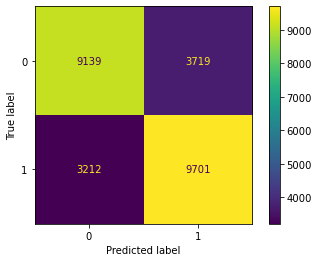

In [55]:
model_rf = RandomForestClassifier(
    bootstrap=True, max_depth=10, max_features=4, n_estimators=200)
model_rf.fit(X_ov_train, y_ov_train)
plot_confusion_matrix(model_rf, X_ov_test, y_ov_test)
plt.show()

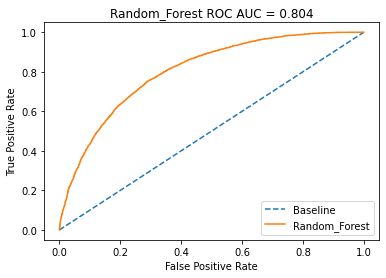

In [56]:
probs = model_rf.predict_proba(X_ov_test)
probs = probs[:, 1]


fpr, tpr, threshold = roc_curve(y_ov_test, probs)
roc_auc = roc_auc_score(y_ov_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Random_Forest')
plt.title('Random_Forest ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [58]:
print('accuracy_score:', accuracy_score(
    y_ov_test, model_rf.predict(X_ov_test)))
print('precision_score:', precision_score(
    y_ov_test, model_rf.predict(X_ov_test)))
print('recall_score:', recall_score(y_ov_test, model_rf.predict(X_ov_test)))
print('f1_score:', f1_score(y_ov_test, model_rf.predict(X_ov_test)))

accuracy_score: 0.7310542858251523
precision_score: 0.7228763040238451
recall_score: 0.7512584217455278
f1_score: 0.736794136634641


# Publishing 

In [59]:
train = banking[banking['train'] == 1]
test = banking[banking['train'] == 0]

X = np.hstack([X_num_train, train[bin_cols].values, X_cat_train])
y = train['default'].values

In [60]:
model = LogisticRegression(C=c, penalty=penalty, class_weight='balanced')
model.fit(X, y)

LogisticRegression(class_weight='balanced')

In [61]:
x_test = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])

In [62]:
y_pred = model.predict_proba(x_test)

In [63]:
y_pred

array([[0.78466901, 0.21533099],
       [0.20385943, 0.79614057],
       [0.68222565, 0.31777435],
       ...,
       [0.20596217, 0.79403783],
       [0.33794473, 0.66205527],
       [0.27842916, 0.72157084]])

In [64]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [65]:
results_df = pd.DataFrame(
    data={'client_id': test['client_id'], 'default': y_pred[:, 1]})

In [66]:
results_df.to_csv('D_submission.csv', index=False)

In [67]:
results_df

client_id   default
0          74835  0.215331
1          17527  0.796141
2          75683  0.317774
3          26883  0.388230
4          28862  0.150657
...          ...       ...
36344      83775  0.794693
36345     106254  0.089483
36346      81852  0.794038
36347       1971  0.662055
36348      69044  0.721571

[36349 rows x 2 columns]

# Publishing oversampling

In [68]:
oversample = RandomOverSampler(sampling_strategy=1)
X_ov, y_ov = oversample.fit_resample(X, y)

In [69]:
X_ov_train, X_ov_test, y_ov_train, y_ov_test = train_test_split(
    X_ov, y_ov, test_size=0.2, shuffle=True, random_state=23
)

In [70]:
warnings.filterwarnings("ignore")
# Add regularisation types
penalty = ['l1', 'l2']
# Add restrictions fo rregularisation
C = np.logspace(0, 4, 10)
# Add hyperparameters
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_ov_train, y_ov_train)
# Create the Grid
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_ov_train, y_ov_train)
# View best hyperparameters
c = best_model.best_estimator_.get_params()['C']
penalty = best_model.best_estimator_.get_params()['penalty']
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 7.742636826811269


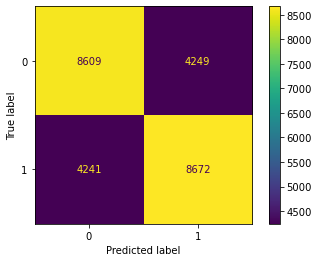

In [71]:
model = LogisticRegression(C=c, penalty=penalty, max_iter=1000)
model.fit(X_ov_train, y_ov_train)
plot_confusion_matrix(model, X_ov_test, y_ov_test)
plt.show()

In [72]:
train = banking[banking['train'] == 1]
test = banking[banking['train'] == 0]

In [73]:
x_test = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])

In [74]:
y_pred = model.predict_proba(x_test)

In [75]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [76]:
results_df = pd.DataFrame(
    data={'client_id': test['client_id'], 'default': y_pred[:, 1]})

In [77]:
results_df.to_csv('D_submission_ov.csv', index=False)

In [78]:
results_df

client_id   default
0          74835  0.218824
1          17527  0.797348
2          75683  0.315140
3          26883  0.384117
4          28862  0.151030
...          ...       ...
36344      83775  0.794710
36345     106254  0.088278
36346      81852  0.795742
36347       1971  0.660441
36348      69044  0.723024

[36349 rows x 2 columns]

# Publishing oversampling Random_Forest

In [79]:
oversample = RandomOverSampler(sampling_strategy=1)
X_ov, y_ov = oversample.fit_resample(X, y)

In [80]:
X_ov_train, X_ov_test, y_ov_train, y_ov_test = train_test_split(
    X_ov, y_ov, test_size=0.2, shuffle=True, random_state=23
)

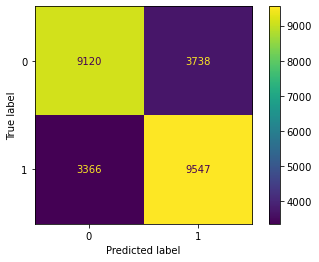

In [81]:
model_rf = RandomForestClassifier(
    bootstrap=True, max_depth=10, max_features=4, n_estimators=200)
model_rf.fit(X_ov_train, y_ov_train)
plot_confusion_matrix(model_rf, X_ov_test, y_ov_test)
plt.show()

In [82]:
train = banking[banking['train'] == 1]
test = banking[banking['train'] == 0]

In [83]:
x_test = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])

In [84]:
y_pred = model_rf.predict_proba(x_test)

In [85]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [86]:
results_df = pd.DataFrame(
    data={'client_id': test['client_id'], 'default': y_pred[:, 1]})

In [87]:
results_df.to_csv('D_submission_ov_rf.csv', index=False)

In [89]:
#For some reason, RF with Grid shows very good ROC, but way worse results on kaggle
#Best results on kaggle - for Logreg with Grid